# 2.1 Prédiction des calories brulées (régression)

## 2.1.1 Ajustement des données 

imports:

In [19]:
#install.packages("plotly")
#install.packages("FactoMineR")
#install.packages("factoextra")
#install.packages("glmnet")
#install.packages("ggfortify")
#install.packages("pROC")
#install.packages("ROCR")
#install.packages("corrplot")
install.packages("fastDummies")


Installation du package dans 'C:/Users/Thomas/AppData/Local/R/win-library/4.4'
(car 'lib' n'est pas spécifié)



le package 'fastDummies' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\Thomas\AppData\Local\Temp\RtmpKuMO8f\downloaded_packages


In [20]:
library(fastDummies)
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

Warning message:
"le package 'fastDummies' a été compilé avec la version R 4.4.3"


In [11]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
data <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

In [12]:
data[, "Gender"] <- as.factor(data[, "Gender"])
data[, "Workout_Type"] <- as.factor(data[, "Workout_Type"])
data[, "Experience_Level"] <- as.factor(data[, "Experience_Level"])
data[, "Workout_Frequency..days.week."] <- as.factor(data[, "Workout_Frequency..days.week."])

In [13]:
data[, "sBMI"] <- sqrt(data[, "BMI"])
data[, "sWeight..kg."] <- sqrt(data[, "Weight..kg."])
data[, "sCalories_Burned"] <- sqrt(data[, "Calories_Burned"])
lambda = 2
data[, "BCFat_Percentage"] <- (data[, "Fat_Percentage"]**lambda)/lambda

In [14]:
data <- data[, c(1:2, 4:8, 10, 12:14, 16:19)]

In [15]:
head(data)

,Age,Gender,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_Type,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,sBMI,sWeight..kg.,sCalories_Burned,BCFat_Percentage
,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,Male,1.71,180,157,60,1.69,Yoga,3.5,4,3,5.495453,9.396808,36.23534,79.380
2,46,Female,1.53,179,151,66,1.30,HIIT,2.1,4,2,5.656854,8.654479,29.71532,574.605
3,32,Female,1.66,167,122,54,1.11,Cardio,2.3,4,2,4.970915,8.252272,26.01922,557.780
4,25,Male,1.70,190,164,56,0.59,Strength,2.1,3,1,4.290688,7.293833,23.06513,414.720
5,38,Male,1.79,188,158,68,0.64,Strength,2.8,3,1,3.793415,6.789698,23.57965,426.320
6,56,Female,1.68,168,156,74,1.59,HIIT,2.7,5,3,4.533211,7.615773,33.40659,120.125


In [22]:

data_factor = data[, c(2,8,10,11)]

dataDum <- dummy_cols(data, select_columns = c("Gender","Workout_Type","Workout_Frequency..days.week.","Experience_Level"), remove_selected_columns = TRUE)

head(dataDum)

,Age,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Water_Intake..liters.,sBMI,sWeight..kg.,sCalories_Burned,⋯,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Workout_Frequency..days.week._2,Workout_Frequency..days.week._3,Workout_Frequency..days.week._4,Workout_Frequency..days.week._5,Experience_Level_1,Experience_Level_2,Experience_Level_3
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,56,1.71,180,157,60,1.69,3.5,5.495453,9.396808,36.23534,⋯,0,0,1,0,0,1,0,0,0,1
2,46,1.53,179,151,66,1.30,2.1,5.656854,8.654479,29.71532,⋯,1,0,0,0,0,1,0,0,1,0
3,32,1.66,167,122,54,1.11,2.3,4.970915,8.252272,26.01922,⋯,0,0,0,0,0,1,0,0,1,0
4,25,1.70,190,164,56,0.59,2.1,4.290688,7.293833,23.06513,⋯,0,1,0,0,1,0,0,1,0,0
5,38,1.79,188,158,68,0.64,2.8,3.793415,6.789698,23.57965,⋯,0,1,0,0,1,0,0,1,0,0
6,56,1.68,168,156,74,1.59,2.7,4.533211,7.615773,33.40659,⋯,1,0,0,0,0,0,1,0,0,1


In [23]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(dataDum) # nombre de lignes dans les données
nvar <- ncol(dataDum) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 


datappr0 <- dataDum[appri, -11] 
datestr0 <- dataDum[testi, -11] 

In [24]:
datappr=datappr0
datappr[,-c(1,2,5)]=scale(datappr0[,-c(1,2,5)])

# on normalise l'échantillon test 
# à l'aide des caractéristiques de l'échantillon d'apprentissage
datestr=datestr0
datestr[,-c(1,2,5)]=scale(datestr0[,-c(1,2,5)],center=sapply(datappr0[,-c(1,2,5)],mean),scale=sapply(datappr0[,-c(1,2,5)],sd))
summary(datestr)

      Age          Height..m.       Max_BPM            Avg_BPM        
 Min.   :18.00   Min.   :1.500   Min.   :-1.69540   Min.   :-1.63883  
 1st Qu.:25.50   1st Qu.:1.610   1st Qu.:-0.75165   1st Qu.:-0.87705  
 Median :37.00   Median :1.710   Median : 0.10631   Median : 0.02323  
 Mean   :36.94   Mean   :1.726   Mean   : 0.05263   Mean   : 0.03531  
 3rd Qu.:47.00   3rd Qu.:1.820   3rd Qu.: 0.87847   3rd Qu.: 0.88889  
 Max.   :59.00   Max.   :2.000   Max.   : 1.65063   Max.   : 1.75454  
  Resting_BPM    Session_Duration..hours. Water_Intake..liters.
 Min.   :50.00   Min.   :-2.22809         Min.   :-1.84575     
 1st Qu.:56.00   1st Qu.:-0.55169         1st Qu.:-0.52560     
 Median :61.00   Median : 0.11590         Median : 0.13448     
 Mean   :61.93   Mean   : 0.08121         Mean   : 0.06678     
 3rd Qu.:68.00   3rd Qu.: 0.66481         3rd Qu.: 0.71204     
 Max.   :74.00   Max.   : 2.19285         Max.   : 1.78467     
      sBMI           sWeight..kg.      sCalories_Burned

In [26]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

## 2.2 Régression par modèles linéaires 


Call:
lm(formula = sCalories_Burned ~ ., data = datappr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56040 -0.07267  0.00352  0.07802  0.39233 

Coefficients: (4 not defined because of singularities)
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -0.0387760  0.5358138  -0.072   0.9423    
Age                             -0.0118504  0.0003636 -32.590  < 2e-16 ***
Height..m.                       0.2545022  0.3101346   0.821   0.4121    
Max_BPM                          0.0048163  0.0044624   1.079   0.2808    
Avg_BPM                          0.3232807  0.0044271  73.024  < 2e-16 ***
Resting_BPM                      0.0010300  0.0006036   1.707   0.0883 .  
Session_Duration..hours.         0.9479217  0.0070881 133.734  < 2e-16 ***
Water_Intake..liters.            0.0010647  0.0070619   0.151   0.8802    
sBMI                             0.0495838  0.0697781   0.711   0.4776    
sWeight..kg.                    

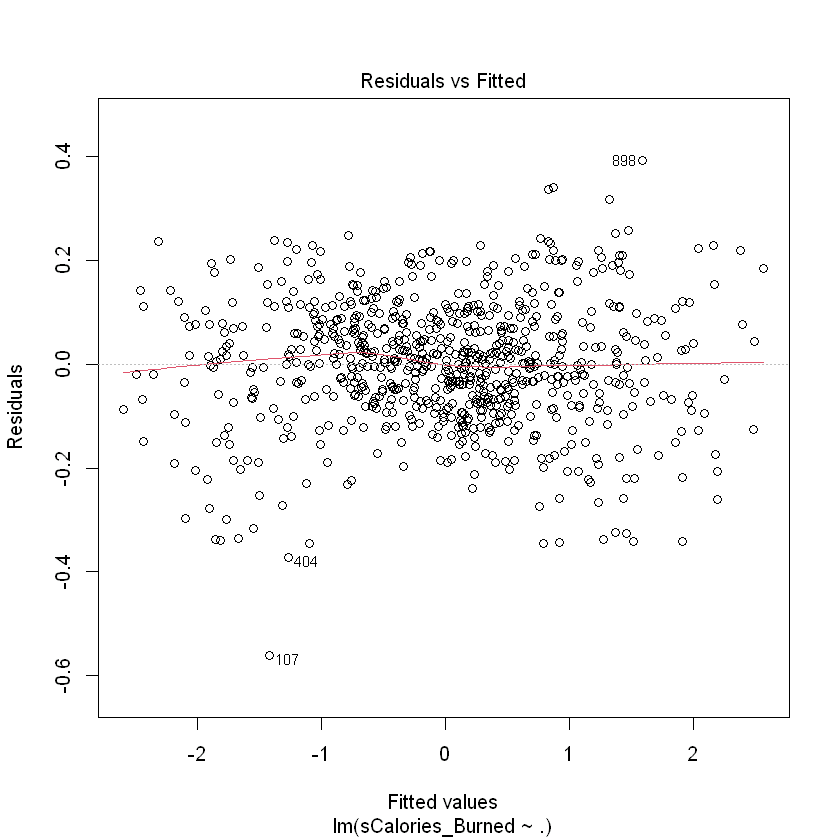

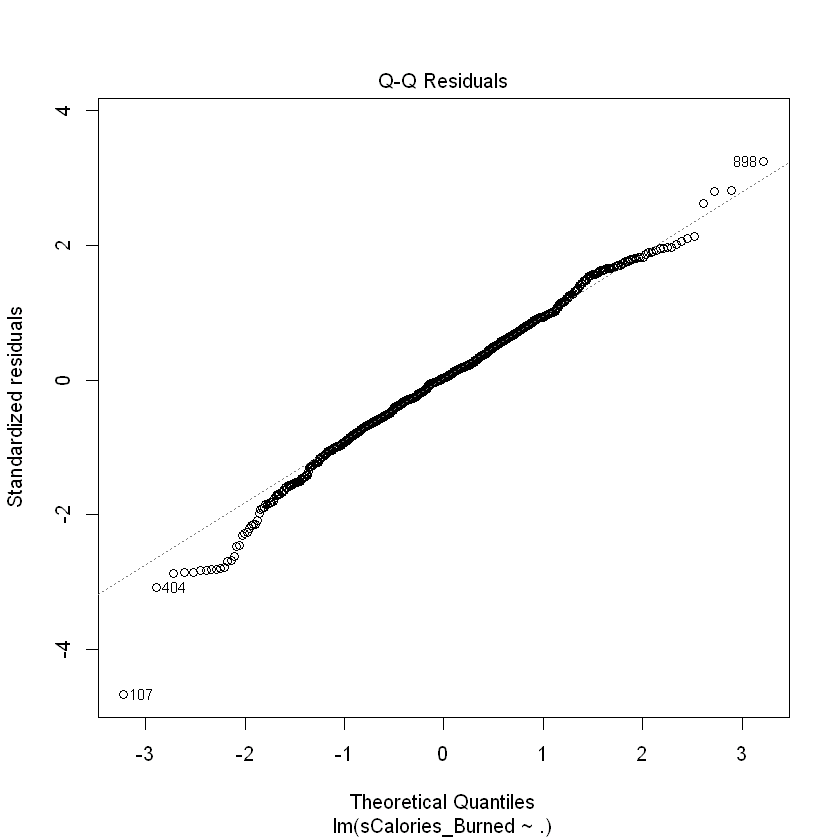

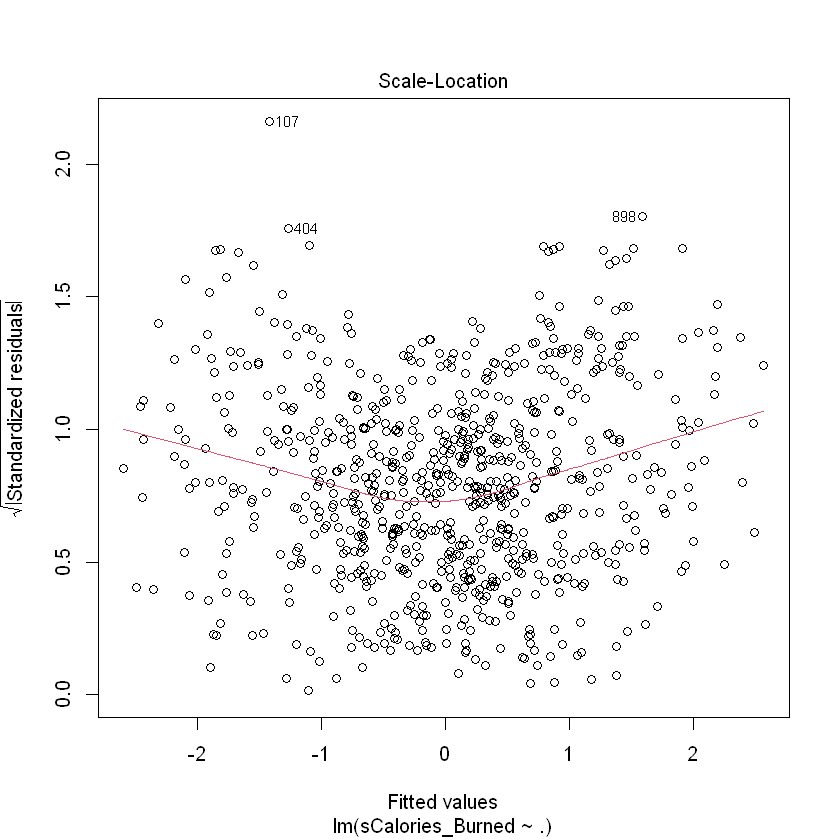

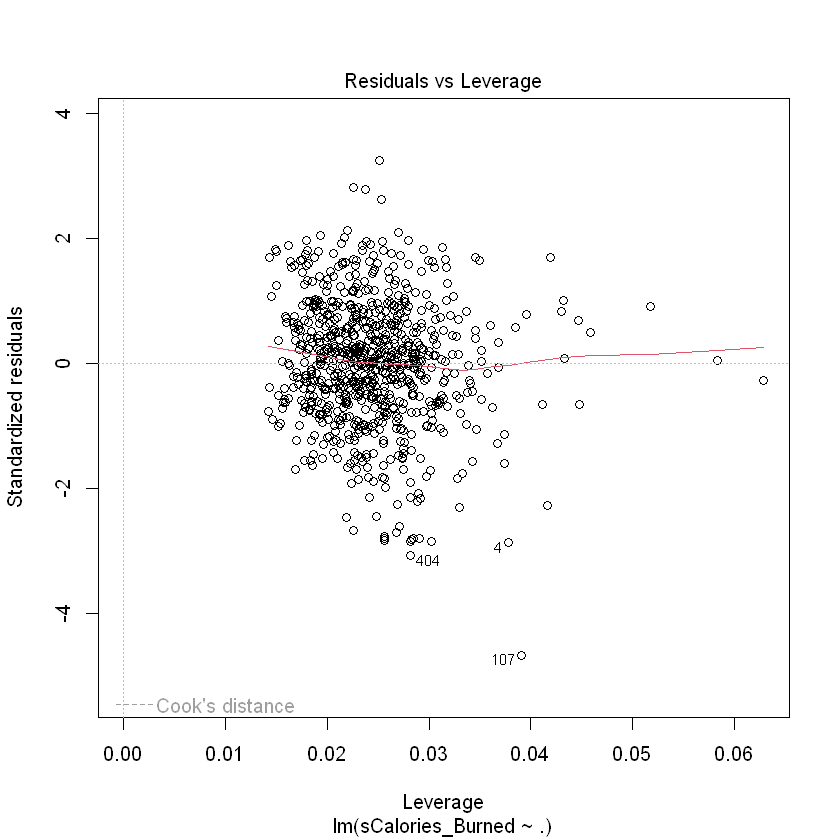

In [32]:
# estimation du modèle sans interaction
reg = lm(sCalories_Burned ~ ., data = datappr)
#abline(reg, col = "blue")

summary(reg)

plot(reg)

In [35]:
prediction <- predict(reg, newdata = datestr)
rmse <- sqrt(mean((datestr$y - prediction)^2))

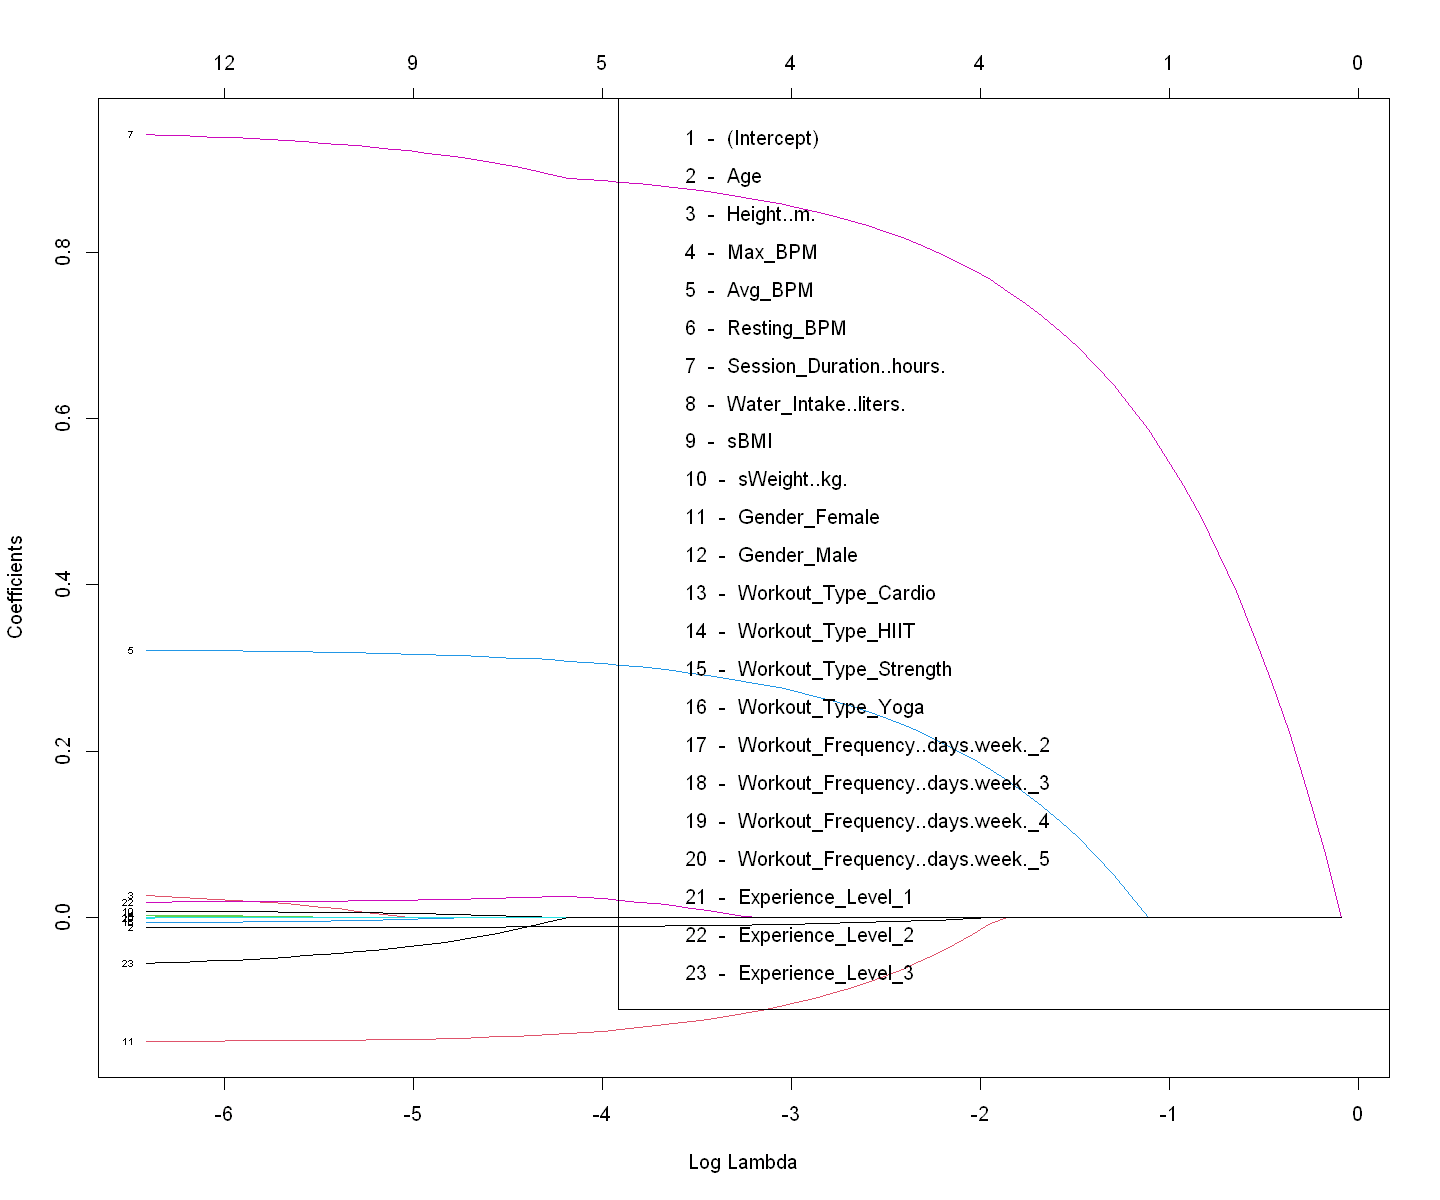

In [36]:
x.mat <- model.matrix(sCalories_Burned ~ . , data = datappr)
reg.lasso <- glmnet(y = datappr$sCalories_Burned, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))